## **Reuse cifar10 autoencoder on mnist with MLP**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from keras.datasets import cifar10
from keras.utils import np_utils
from numba import njit
import cv2
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
input_units = 784      #input− 2048- 1000− 2048- output
hidd1_units= 2048      #number of units in the first hidden layer
output1_units = input_units
nb_classes = 10
#input_img = Input(shape=(3072,))
#s=3072

###**LOAD DATA SET**

In [ ]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

assert X_train.shape[-1] == 3
assert X_test.shape[-1] == 3

170500096/170498071 [==============================] - 3s 0us/step


In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

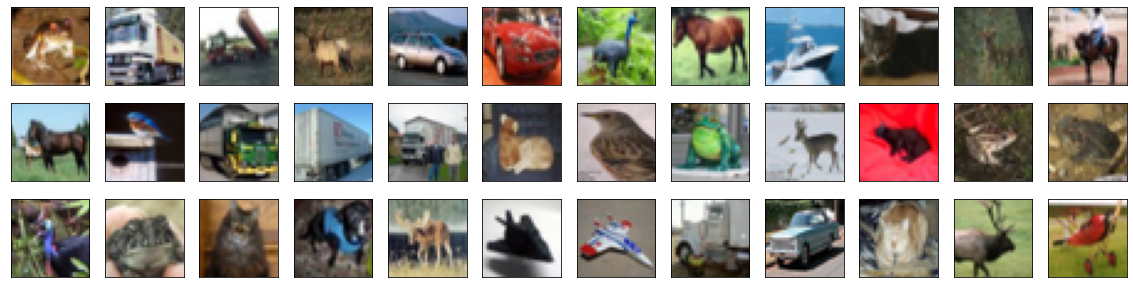

In [ ]:
# the images are matrices itself, meaning we will use numpy to read them in and matplotlib to "plot" them. 
%matplotlib inline
def plot_images(X_train):
    fig = plt.figure(figsize=(20,5))
    for i in range(36):
        ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_train[i]))
plot_images(X_train)

In [ ]:
def load_data(data):
    X = []
    for img in data:
        img_array = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        img_pil = Image.fromarray(img_array)
        img_28x28 = np.array(img_pil.resize((28, 28), Image.ANTIALIAS))
        
        X.append(img_28x28)

    return X

In [ ]:
X_train = load_data(X_train) 
X_test = load_data(X_test)

In [ ]:
# one-hot encode the labels
# convert class vectors to binary class matrices
nb_classes = len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

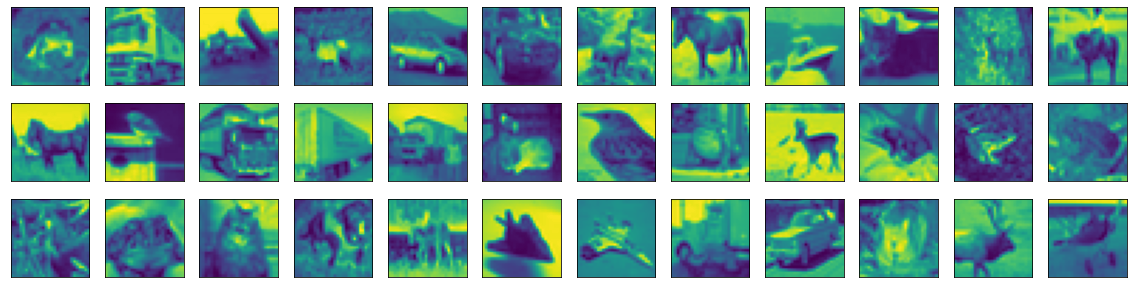

In [ ]:
# the images are matrices itself, meaning we will use numpy to read them in and matplotlib to "plot" them. 
%matplotlib inline
def plot_images(X_train):
    fig = plt.figure(figsize=(20,5))
    for i in range(36):
        ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_train[i]))
plot_images(X_train)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
print("[cifar] X_train.shape={}, y_train.shape={}".format(X_train.shape, y_train.shape))
print("[cifar] X_test.shape={}, y_test.shape={}".format(X_test.shape, y_test.shape))

[cifar] X_train.shape=(50000, 28, 28), y_train.shape=(50000, 10)
[cifar] X_test.shape=(10000, 28, 28), y_test.shape=(10000, 10)


In [ ]:
X_train = X_train.reshape(50000, 784)
X_test = X_test.reshape(10000, 784)
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

(50000, 784) train samples
(10000, 784) test samples


###**DEFNINE AUTOENCODER-1 MODEL ARCHITECTURE**

In [ ]:
#AUTOENCODER-1
ae_model1 = Sequential()
ae_model1.add(Dense(hidd1_units, input_dim=input_units, kernel_initializer='uniform', activation='relu'))
ae_model1.add(Dense(output1_units, activation='sigmoid'))
ae_model1.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

### **TRAIN AUTOENCODER-1**

In [ ]:
ae_model1.fit(X_train, X_train, epochs=1, batch_size=32, shuffle=True)

1563/1563 [==============================] - 39s 24ms/step - loss: 0.0196 - accuracy: 0.0230


In [ ]:
ae_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              1607680   
_________________________________________________________________
dense_1 (Dense)              (None, 784)               1606416   
Total params: 3,214,096
Trainable params: 3,214,096
Non-trainable params: 0
_________________________________________________________________


**SAVE MODEL-1 WEIGHT**

In [ ]:
g1=ae_model1.get_config()
h1=ae_model1.get_weights()

In [ ]:
#Note here that enc is hidden layer and dec is output layer
enc1_w= h1[0]
enc1_bias_w= h1[1]
enc1_dec1_w= h1[2]
dec1_bias_w= h1[3]

In [ ]:
#concatenate horizonatlly as array list module1 enc1 and enc1_bias weights
enc1_with_bias_w= [(enc1_w), (enc1_bias_w)]     #keep this for deep model fine-tuning
enc1_w_trans= np.transpose(enc1_w)    #transpose enc1 weights

In [ ]:
#get shape for enc1 bias from input data size
#Note that by default (originally), input data has samples as rows and attributes as columns
[x1, y1] = np.shape(np.transpose(X_train))

In [ ]:
#Here, activations computation follow my usual way; y= W(transpose)*x + bias weight*1s
enc1_bias_inp = np.ones((1,y1), dtype= np.int)

In [ ]:
def mat(x1,x2):
    m = np.matmul(x1, np.transpose(x2))
    return m

@njit()
def matt(x3,x4):
    mm = np.outer(x3, x4)
    return mm


In [ ]:
#compute the pre-activations of enc1, including bias contribution
enc1_pre_acts = mat(enc1_w_trans, X_train) + matt(enc1_bias_w, enc1_bias_inp)

In [ ]:
#Pass enc1 pre-activations through activation function to obtain enc1 activations
#Here list the common activation functions implementation in numpy
#NOTE: use the same activation function used in the pre-training phase of enc1
#ReLU: y= np.maximum(x, 0, x); sigmoid: y= 1 / (1 + np.exp(-x)); tanh: y = np.tanh(x)
enc1_acts= np.maximum(enc1_pre_acts, 0, enc1_pre_acts)  #enc1 activations here

###**DEFNINE AUTOENCODER-2 MODEL**

In [ ]:
#Transpose enc1 activation into Keras original format
ae_model2_input= np.transpose(enc1_acts)

In [ ]:
hidd1_units

2048

In [ ]:
#Set auto encoder 2 parameters
enc2_input_units = hidd1_units
hidd2_units= 1000          #number of units in the second hidden layer
output2_units = enc2_input_units

In [ ]:
output2_units

2048

###**AUTOENCODER-2 MODEL ARCHITECTURE**

In [ ]:
#Define AE_model2 architecture
ae_model2 = Sequential()
ae_model2.add(Dense(hidd2_units, input_dim= enc2_input_units, kernel_initializer='uniform', activation='relu'))
ae_model2.add(Dense(output2_units, activation='sigmoid'))
ae_model2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

### **TRAIN AUTOENCODER-2**

In [ ]:
ae_model2.fit(ae_model2_input, ae_model2_input, epochs=1, batch_size=32, shuffle=True)

1563/1563 [==============================] - 65s 41ms/step - loss: 0.0250 - accuracy: 0.3871


In [ ]:
ae_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              2050048   
Total params: 4,099,048
Trainable params: 4,099,048
Non-trainable params: 0
_________________________________________________________________


**SAVE MODEL-2 WEIGHT**

In [ ]:
g2=ae_model2.get_config()
h2=ae_model2.get_weights()

In [ ]:
#Note here that enc is hidden layer and dec is output layer
enc2_w= h2[0]
enc2_bias_w= h2[1]
enc2_dec2_w= h2[2]
dec2_bias_w= h2[3]

In [ ]:
#concatenate horizonatlly as array list module1 enc and bias weights
enc2_with_bias_w= [(enc2_w), (enc2_bias_w)]     #keep this for deep model fine-tuning

###**DEFINE FINE TUNING MODEL ARCHITECTURE**

In [ ]:
#Finetune(ft) model using encoder weights of trained auto encoder
model_ft = Sequential()
module1_enc_ft_w= [(enc1_w), (enc1_bias_w)]

model_ft.add(Dense(hidd1_units, input_dim=input_units, kernel_initializer='uniform', activation='relu'))
model_ft.layers[0].set_weights(enc1_with_bias_w)

model_ft.add(Dense(hidd2_units, activation='relu'))
model_ft.layers[1].set_weights(enc2_with_bias_w)

model_ft.add(Dense(output1_units, activation='softmax'))
model_ft.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mse'])

In [ ]:
model_ft.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              1607680   
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_6 (Dense)              (None, 784)               784784    
Total params: 4,441,464
Trainable params: 4,441,464
Non-trainable params: 0
_________________________________________________________________


### **TRAIN AUTOENCODER**

In [ ]:
from keras.callbacks import ModelCheckpoint   
import time

mlp_start = time.time() # for stopwatch

history = model_ft.fit(X_train, X_train, epochs=5, batch_size=32, validation_data=(X_test, X_test),
                            verbose=2, shuffle=True)

mlp_end = time.time()
mlp_took = mlp_end -mlp_start

Epoch 1/5
1563/1563 - 56s - loss: 567446912.0000 - accuracy: 0.0013 - mse: 0.2814 - val_loss: 1536543744.0000 - val_accuracy: 0.0032 - val_mse: 0.2843
Epoch 2/5
1563/1563 - 56s - loss: 3570040832.0000 - accuracy: 0.0016 - mse: 0.2814 - val_loss: 5186015232.0000 - val_accuracy: 6.0000e-04 - val_mse: 0.2843
Epoch 3/5
1563/1563 - 56s - loss: 6739588608.0000 - accuracy: 0.0014 - mse: 0.2814 - val_loss: 9069107200.0000 - val_accuracy: 0.0019 - val_mse: 0.2843
Epoch 4/5
1563/1563 - 56s - loss: 10725391360.0000 - accuracy: 0.0012 - mse: 0.2814 - val_loss: 13257420800.0000 - val_accuracy: 0.0021 - val_mse: 0.2841
Epoch 5/5
1563/1563 - 56s - loss: 15210226688.0000 - accuracy: 0.0014 - mse: 0.2814 - val_loss: 16496723968.0000 - val_accuracy: 2.0000e-04 - val_mse: 0.2844


#**EVALUATE MNIST DATASET ON CIFAR MLP MODEL**

# **UPLOAD MNIST DATASET**

In [ ]:
from keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(X_train.shape, y_train.shape),
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
X_train = X_train.reshape(60000,784)
X_test = X_test.reshape(10000,784)

In [ ]:
train_perf = model_ft.evaluate(X_train, X_train, verbose=0)
test_perf = model_ft.evaluate(X_test, X_test, verbose=0)
print('Train accuracy:', train_perf[1])
print('Test accuracy:', test_perf[1])

Train accuracy: 0.0017166666220873594
Test accuracy: 0.00139999995008111


In [ ]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

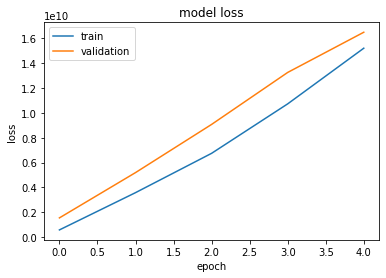

In [ ]:
plotLosses(history)

In [ ]:
score = model_ft.evaluate(X_test, X_test, batch_size=100, verbose=2)

100/100 - 2s - loss: 85242962509824.0000 - accuracy: 0.0014 - mse: 7409.8662


##**MEAN SQUARE ERROR**

In [ ]:
print(model_ft.metrics_names)
print(score)

['loss', 'accuracy', 'mse']
[85242962509824.0, 0.00139999995008111, 7409.8662109375]


In [ ]:
#Next, let's visualize ten of the input images and the reconstructed outputs from auto encoder module1.
decoded_imgs = ae_model1.predict(X_test)
n = 10

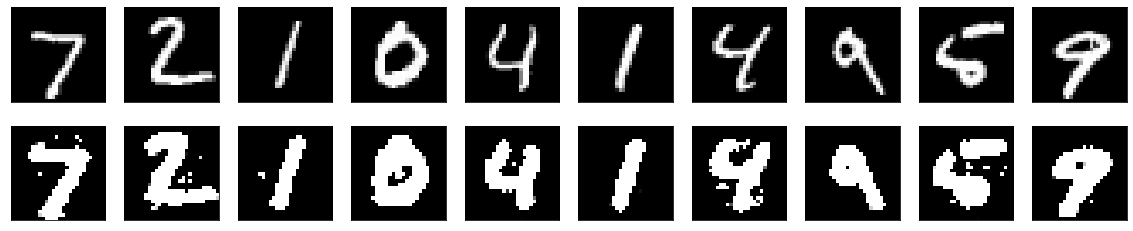

In [ ]:
#Next, let's visualize ten of the input images and the reconstructed outputs from auto encoder module1.
decoded_imgs = ae_model1.predict(X_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    #Convert test image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #How many items to display
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##**MEAN SQUARED ERROR**

In [ ]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(X_test, decoded_imgs)
MSE

7342.8276